In [1]:
from imf import Salpeter,Kroupa,ChabrierLogNormal,ChabrierPowerLaw,KoenConvolvedPowerLaw
from imf import make_cluster
import numpy as np
from scipy.integrate import quad
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
def normalization(max_star,massfunc):
    return 1/massfunc.integrate(max_star,massfunc.mmax)[0]

def hist_props(stars,massfunc):
    edges = [stars[0]*1.01]
    for i in range(1,np.floor_divide(len(stars),10)):
        try:
            edge = (stars[10*i-1]+stars[10*i])/2
            edges.append(edge)
        except(IndexError):
            continue
    edges.append(massfunc.mmin)
    edges = np.array(edges)[::-1]
    dm = edges[1:]-edges[:-1]

    weights = np.ones(len(stars))
    for i in range(len(dm)):
        weights[np.logical_and(stars > edges[i],stars < edges[i+1])] *= 1/dm[i]
        
    return edges,weights

To use optimal sampling, enter it as input to the "sampling' keyword in "make_cluster":

In [3]:
opt_cl = make_cluster(1e3,'kroupa',sampling='optimal')
rand_cl = make_cluster(1e3,'kroupa',stop_criterion='nearest')

Total cluster mass is 999.986 (limit was 1000)
Total cluster mass is 1000.83 (limit was 1000)


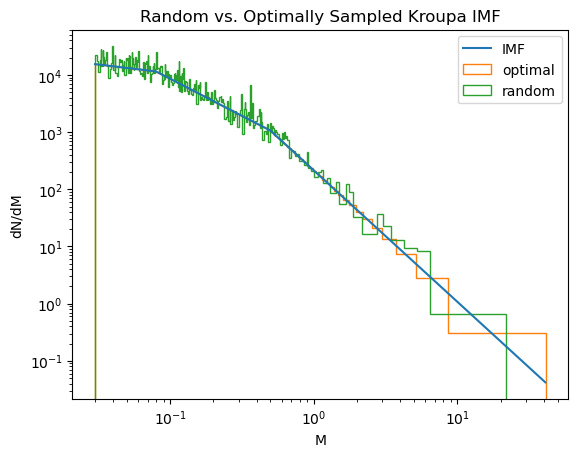

In [4]:
plt.figure()
massfunc = Kroupa()
k = normalization(opt_cl[0],massfunc)
plt.plot(opt_cl,k*massfunc(opt_cl),label='IMF')

edges,weights = hist_props(opt_cl,massfunc)
n,bins,patches = plt.hist(opt_cl,bins=edges,weights=weights,histtype='step',
                          label='optimal',zorder=-2)

rand_cl.sort()
rand_cl = rand_cl[::-1]
edges,weights = hist_props(rand_cl,massfunc)
n,bins,patches = plt.hist(rand_cl,bins=edges,weights=weights,histtype='step',
                          label='random (nearest)',zorder=-1)

plt.title('Random vs. Optimally Sampled Kroupa IMF')
plt.xscale('log'); plt.yscale('log')
plt.xlabel('M'); plt.ylabel('dN/dM')
plt.legend()

It will work with any provided mass function, and you can use make_cluster the same way you would normally use it. However, there are a few considerations specific to optimal sampling that should be kept in mind.

-Optimal sampling assumes a relationship between the mass of a cluster, M_cl, and the largest possible mass of a constituent star, m_max. It also assumes that there is at most one star which can attain this mass. The masses of other stars are obtained by integrating the mass function (scaled to produce one star with mass m_max or greater) all the way down to the minimum.

-Optimal sampling is not random; the stars are determined based on the provided mass function and cluster mass. The "stop_criterion" keyword therefore has no significance to optimal sampling. 

-The stop criterion for optimal sampling is by default the minimum possible stellar mass (i.e. when the available mass is less than that needed to form a star, which is determined by the mmin of the provided mass function. If you instead want to cut off earlier, you can specify a tolerance larger than mmin, and optimal sampling will terminate when the available mass no longer exceeds that tolerance. (The larger of the two values will be used.)

-You can provide a mass function with an mmin of zero. However, you must then specify a mass tolerance with the "tolerance" keyword, or else optimal sampling will never terminate (there can't be any zero-mass stars, so the mass will asymptote to zero but will not reach it.) This will be prompted.

-Currently, the implementation of optimal sampling has difficulties with mass functions of the KoenConvolvedPowerLaw type. These result from the implementation of KoenConvolvedPowerLaw, which relies on numerical integration and interpolation due to not being feasible to implement analytically. The total mass of the returned cluster should be close to the provided mass reservoir, but the cluster may not reproduce the low-mass end of the distribution as accurately.

TESTS

In [5]:
def make_hist(stars,massfunc):
    edges,weights = hist_props(stars,massfunc)
    plt.figure()
    k = normalization(stars[0],massfunc)
    plt.plot(stars,k*massfunc(stars),label='IMF')
    n,bins,patches = plt.hist(stars,bins=edges,weights=weights,histtype='step',label='sampled')
    #plt.title('Random vs. Optimally Sampled Kroupa IMF')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('M'); plt.ylabel('dN/dM')
    plt.legend()

In [6]:
M_res = 1000

Total cluster mass is 999.797 (limit was 1000)


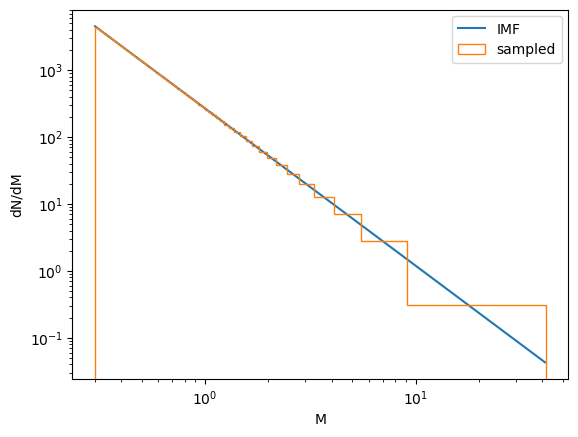

In [7]:
sp = Salpeter()
cl = make_cluster(M_res,massfunc=sp,sampling='optimal')
assert M_res-cl.sum() <= sp.mmin
make_hist(cl,sp)

Total cluster mass is 999.986 (limit was 1000)


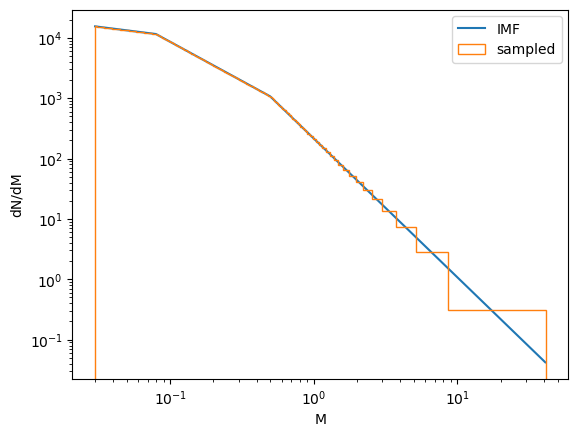

In [8]:
kr = Kroupa()
cl = make_cluster(M_res,massfunc=kr,sampling='optimal')
assert M_res-cl.sum() <= kr.mmin
make_hist(cl,kr)

Total cluster mass is 999.987 (limit was 1000)


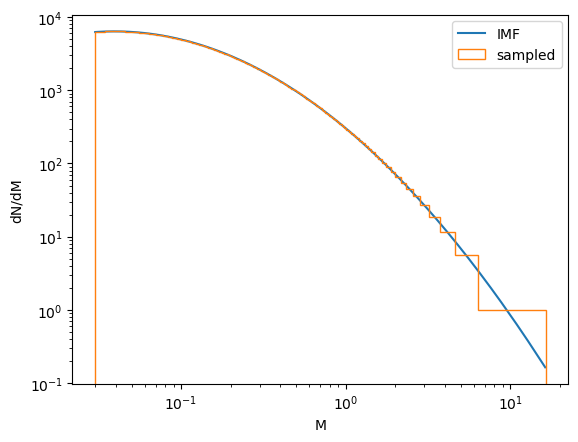

In [9]:
chl = ChabrierLogNormal(mmin=0.03)
cl = make_cluster(M_res,massfunc=chl,sampling='optimal')
assert M_res-cl.sum() <= chl.mmin
make_hist(cl,chl)

Total cluster mass is 1000.0 (limit was 1000)


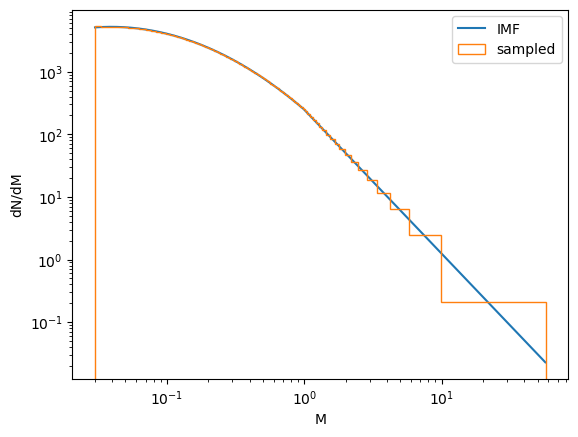

In [10]:
chp = ChabrierPowerLaw(mmin=0.03)
cl = make_cluster(M_res,massfunc=chp,sampling='optimal')
assert M_res-cl.sum() <= chp.mmin
make_hist(cl,chp)

/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:45: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return scipy.integrate.quad(self, mlow, mhigh)
/blue/adamginsburg/richardson.t/research/imf/imf/imf/imf.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling

Reached provided lower mass bound; stopping
Total cluster mass is 999.902 (limit was 1000)
Optimal sampling stopped early: final mass is 0.00981% off


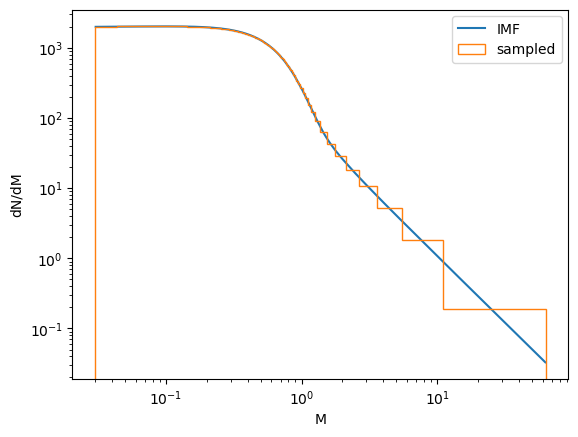

In [11]:
koc = KoenConvolvedPowerLaw(0.03,120,0.9,0.4)
cl = make_cluster(M_res,massfunc=koc,sampling='optimal')
try:
    assert M_res-cl.sum() <= koc.mmin
except(AssertionError):
    pct = abs((M_res-cl.sum())/M_res)*100
    print(f'Optimal sampling stopped early: final mass is {np.round(pct,5)}% off')
make_hist(cl,koc)

In [ ]:
chl = ChabrierLogNormal(mmin=0.03,mmax=150)
cl = make_cluster(M_res*100,massfunc=chl,sampling='optimal')
assert M_res-cl.sum() <= chl.mmin

In [ ]:
chl = ChabrierLogNormal()
try:
    cl = make_cluster(1e3,massfunc=chl,sampling='optimal')
except(ValueError):
    print('Caught exception due to zero mmin and tolerance.')
tolerance = 0.1
cl = make_cluster(1e3,massfunc=chl,sampling='optimal',tolerance=tolerance)
assert M_res-cl.sum() <= tolerance

In [ ]:
ms = np.geomspace(0.03,120,100)
plt.figure()
plt.plot(ms,koc(ms),label=fr'$\gamma$ = {koc.gamma},$\sigma$ = {koc.sigma}')
plt.xscale('log'); plt.yscale('log')
plt.title('Koen/Kondlo 2009 Convolved Powerlaw')
plt.xlabel('Mass (Msun)'); plt.ylabel('dn/dm')
plt.legend()

In [ ]:
from scipy.integrate import simpson

In [ ]:
#koen/kondlo convolved powerlaw PDF integrand
def integrand(y,x,integral_form=False):
    y1 = np.atleast_1d(y)
    if integral_form:
        coef = 1 / (sigma * np.sqrt(2 * np.pi)) / (L**-gamma - U**-gamma)
        ret = coef * (L**-gamma - x**-gamma) * np.exp(-.5 * ((y1[:,None] - x[None,:]) / sigma)**2)
    else:
        coef = gamma / (sigma * np.sqrt(2 * np.pi)) / (L**-gamma - U**-gamma)
        ret = coef / x**(gamma + 1) * np.exp(-.5 * ((y1[:,None] - x[None,:]) / sigma)**2)
    tozero = (y1 < L) | (y1 > U)
    ret[tozero,:] = 0
    return ret

In [ ]:
def steps(L,U,sigma):
    x = np.geomspace(L,U,500)
    dx = x[1:]-x[:-1]
    break1 = np.searchsorted(dx,sigma)
    '''
    x = np.append(x[:break1],np.linspace(x[break1],U,int((U-L)/sigma)))
    '''
    mir_x = U-(x[::-1]-L)
    break2 = np.searchsorted(-dx[::-1],-sigma)
    x = np.append(x[:break1],np.arange(x[break1],mir_x[break2],sigma))
    x = np.append(x,mir_x[break2:])
    #'''
    return x

In [ ]:
def make_function(integral_form=False):
    #mass range of defined mass function (i.e. "self")
    x = steps(L,U,sigma)
    vals = integrand(x,x,integral_form)
    result = np.trapz(vals,x,axis=-1)
    if integral_form:
        result += norm.cdf((x - U) / sigma)
    return result,x

In [ ]:
def log_integrate(L,U,integral_form=False):
    x = np.geomspace(L,U,500)
    x = steps(L,U,sigma)
    log_x = np.log(x)
    vals = integrand(x,x,integral_form)
    result = np.trapz(x[None,:] * vals,log_x,axis=-1)
    if integral_form:
        result += norm.cdf((x - U) / sigma)
    return result,x

In [ ]:
def make_cdf(pdf,x):
    C = np.trapz(integrand(L,x),x)
    C = 0
    return np.trapz(pdf,x)+C

In [ ]:
def repair_cdf(cdf,x):
    for i in range(len(x)-1):
        if cdf[i+1] >= cdf[i]:
            continue
        else:
            try:
                idx = np.where(cdf > cdf[i])[0][0]
            except(IndexError):
                print(i)
            frac = (x[i+1:idx] - x[i]) / (x[idx] - x[i])
            cdf[i+1:idx] = (1-frac)*cdf[i] + frac*cdf[idx]
    return cdf

In [ ]:
def evaluate(y,x,vals):
    return np.interp(y,x,vals)

In [ ]:
L = 0.03
U = 120
gamma = 1.35
sigma = 0.1

In [ ]:
kot = KoenTruePowerLaw(L,U,gamma)
koc = KoenConvolvedPowerLaw(L,U,gamma,sigma)

In [ ]:
pdf,x = make_function()
cdf,x = make_function(True)
#cdf = repair_cdf(cdf,x)

In [ ]:
cdf[-10:],np.argmax(cdf)

In [ ]:
plt.plot(x[x > 100],cdf[x > 100])

In [ ]:
plt.plot(x,kot(x,integral_form=True),label='True')
plt.plot(x,koc(x,integral_form=True),label='Current')
plt.plot(x,evaluate(x,x,cdf),label='Me')
plt.xscale('log')#; plt.yscale('log')
plt.legend()
#plt.ylim(1e-1,1.1)
plt.title(fr'L = {L}, U = {U}, $\gamma$ = {gamma}, $\sigma$ = {sigma}')
plt.xlabel(r'Mass ($M_\odot$)')
plt.ylabel('PDF')

In [ ]:
plt.plot(x,pdf)
plt.xscale('log')
plt.yscale('log')
plt.title('Me')
plt.xlabel(r'Mass ($M_\odot$)')
plt.ylabel('PDF')

In [ ]:
plt.plot(x,cdf)
plt.xscale('log')
plt.title('Me')
plt.xlabel(r'Mass ($M_\odot$)')
plt.ylabel('CDF')

In [ ]:
plt.plot(x,pdf/koc(x,integral_form=False))
plt.xscale('log')
plt.title('Me/Current')
plt.xlabel(r'Mass ($M_\odot$)')
plt.ylabel('Ratio')
plt.ylim(0.95,1.05)

In [ ]:
np.median((evaluate(x,x,cdf)/koc(x,integral_form=True))[x<20])

In [ ]:
my_int = np.trapz(evaluate(x,x,pdf),x)
alt_int = evaluate(U,x,cdf)-evaluate(L,x,cdf)
their_int = np.trapz(koc(x),x)
pct1 = (abs(my_int-their_int)/their_int)*100
pct2 = (abs(alt_int-their_int)/their_int)*100
print(f'{np.round(pct1,2)}% difference from PDF')
print(f'{np.round(pct2,2)}% difference from CDF')

In [ ]:
x = np.geomspace(koc.mmin-3*koc.sigma,koc.mmax+3*koc.sigma,100) #mass range of defined mass function (i.e. "self")
y = np.geomspace(koc.mmin,koc.mmax,15)
foo = integrand(x[None,:],y[:,None])
trapz_result = np.trapz(foo,x,axis=-1)
call_result = koc(y)

In [ ]:
np.isclose(trapz_result,call_result,atol=0.)
trapz_result/call_result

In [ ]:
trapz_result

In [ ]:
np.trapz(np.interp(x,y,trapz_result),x)